# Computer Lab: The Dew Point and Wet Bulb Temperature
As a human being, you are using about 100W of energy when in rest. This energy is converted into heat, and then has to be moved out of your body into the environment. This is done by radiation of sensible heat if the environment is cold enough. If it is not, we start to sweat, and are cooled of by the energy that is needed to evaporate the sweat.

To express the ease with which sweat can evaporate, meteorologists use two different temperatures: the *dew point temperature $T_d$* and the *wet bulb temperature $T_w$*. In this computer lab, we will start working with both of them.

### The Dew Point Temperature
The Dew Point Temperature is defined as the temperature to which we need to cool the air for the water in it to start condensating. 

### The Wet Bulb Temperature
The Wet-bulb Temperature is the temperature an air parcel would have if cooled adiabatically to saturation at constant pressure by evaporation of water into it, all latent heat being supplied by the parcel.
In other words, this is the temperature your body would be after evaporating the sweat. If the wet-bulb temperature is lower than the body temperature, you can use sweating to transport heat away from your body.

### The Feels-Like Temperature
The Wet-Bulb temperature is a more accurate expression of the Feels Like temperature. 
The Feels-Like temperature is usually a tweaked algorithm from commercial weather forecasting services; no official definition exists. It tries to express the effect of humidity as *what would the absolute temperature at low humidity be so that it heat exchange from the body is the same*. 



### Q1
The Dew Point Temperature is always lower than the Absolute Temperature, and the Wet Bulb Temperature is always somewhere in between. Can you argue why? 

In [1]:
#First, load some libraries. Just press Shift+Enter
import numpy as np
import xarray as xr
import metpy.calc as mpcalc
from metpy.units import units
import matplotlib.pyplot as plt
import fsspec
import xarray as xr

import metpy.calc as mpcalc
from metpy.interpolate import cross_section
from metpy.units import units
from metpy.plots import USCOUNTIES

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd

def plot_map(data, time, var, units=None):
    if units==None:
        units = data[var].metpy.units

    map_extent = (data.longitude.data[0], data.longitude.data[-1], data.latitude.data[-1], data.latitude.data[0])

    fig = plt.figure(1, figsize=(8,6))
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02], bottom=.07, top=.99,
                        hspace=0.01, wspace=0.01)

    plotcrs = ccrs.LambertConformal(central_latitude=(map_extent[2]+map_extent[3])/2, central_longitude=(map_extent[0]+map_extent[1])/2)
    ax = plt.subplot(gs[0], projection=plotcrs)
    plt.contourf(data.longitude, data.latitude, data[var][time,:,:].metpy.convert_units(units),levels=20,
                transform=ccrs.PlateCarree(), extend='max', cmap=get_cmap("YlOrRd"))
    ax.coastlines('50m', edgecolor='black', linewidth=0.75)
    ax.set_extent(map_extent)
    ax.add_feature(cfeature.STATES, linewidth=1)
    ax.add_feature(USCOUNTIES.with_scale('500k'), linewidth=0.5, edgecolor='gray')

    plt.colorbar(label = data[var].attrs['long_name'] + '(%s) '%units)
    plt.title(data.time.dt.strftime('%c (UTC)').data[time] )
    plt.show()
    


In [ ]:
#Download the 
do_download = False
if do_download:
    import cdsapi

    c = cdsapi.Client()
    # years = np.range(1950,2021)
    c.retrieve(
        'reanalysis-era5-land',
        {
            'format': 'netcdf',
            'variable': ['2m_temperature','2m_dewpoint_temperature','surface_pressure'],
            
            'year': ['2021'],
            'month': [
                '06'
            ],
            'day': [
                '25', '26', '27',
                '28', '29', '30',
                '31',
            ],
            'time': [
                '00:00', '01:00', '02:00',
                '03:00', '04:00', '05:00',
                '06:00', '07:00', '08:00',
                '09:00', '10:00', '11:00',
                '12:00', '13:00', '14:00',
                '15:00', '16:00', '17:00',
                '18:00', '19:00', '20:00',
                '21:00', '22:00', '23:00',
            ],
            'area': [
                51, -128, 43,
                -118,
            ],
        },
        'PNW.nc')
        
    c.retrieve(
        'reanalysis-era5-land',
        {
            'format': 'netcdf',
            'variable': ['2m_temperature','2m_dewpoint_temperature','surface_pressure'],
            
            'year': ['1995'],
            'month': [
                '07'
            ],
            'day': [
                '13','14','15',
            ],
            'time': [
                '00:00', '01:00', '02:00',
                '03:00', '04:00', '05:00',
                '06:00', '07:00', '08:00',
                '09:00', '10:00', '11:00',
                '12:00', '13:00', '14:00',
                '15:00', '16:00', '17:00',
                '18:00', '19:00', '20:00',
                '21:00', '22:00', '23:00',
            ],
            'area': [
                43, -90, 40,
                -86,
            ],
        },
        'Chicago.nc')


## Question 2: Radiative transfer of sensible heat
First, let's calculate the sensible heat flux due to radiation, using $P=\sigma A (T_0^4 - T_1^4)$, with $\sigma$ the Stefan Boltzmann constant, and Area the area of the human body. We'll be using some reasonable numbers, but of course exact details will vary from person to person.

In [2]:
#Set some coefficients
boltzmann = 5.67e-8 * units('W/(m^2K^4)') #The Stefan-Boltzmann Constant
area = 1.9 * units('m^2') #The body area of an adult man, from: https://www.calculator.net/body-surface-area-calculator.html
tskin = 34 * units('degC') # The temperature of the skin, in Celcius

### Q2.1: What is the maximum power output due to radiation if the environmental temperature is 70F? 

In [3]:
tenv = 70 * units('degF')

def radiation(tenv):
    #Calculate the Power; don't forget to convert your temperature to Kelvin!
    T0 = tskin.to(units('K'))
    T1 = tenv.to(units('K'))

    power = boltzmann * area * (T0**4 - T1**4)
    return power

radiation(tenv)

151.0900650430508 <Unit('watt')>

## What happens if the a) temperature outside is warmer (say, 90F), or b) when you have a fever, elevating your skin  temperature to 35C?  

### Q2.2: Create a graph of power output as a function of temperature. At what temperature does the power output reach 100W?

Once the temperature reaches the value necessary for 100W, sweating will be required for thermoregulation.

In [ ]:
#Create a range of temperatures
tenv = np.arange(60.,90.)* units('degF')
print(tenv)
#Calculate the Power; don't forget to convert your temperature to Kelvin!
T0 = tskin.to(units('K'))
T1 = tenv.to(units('K'))
power = boltzmann * area * (T0**4 - T1**4)
print(power)

[60.0 61.0 62.0 63.0 64.0 65.0 66.0 67.0 68.0 69.0 70.0 71.0 72.0 73.0 74.0 75.0 76.0 77.0 78.0 79.0 80.0 81.0 82.0 83.0 84.0 85.0 86.0 87.0 88.0 89.0] degree_Fahrenheit
[210.38324842591453 204.60570875786593 198.7947839451225 192.95034562544296 187.07226519029146 181.1604137848342 175.21466230794124 169.23488141218692 163.22094150384828 157.1727127429081 151.0900650430508 144.9728680716655 138.82099124984404 132.63430375238394 126.41267450778466 120.15597219824977 113.86406525968687 107.53682188170623 101.17411000762402 94.77579733445828 88.341751312931 81.87183914746757 75.36592779619886 68.82388397095757 62.245574137280784 55.63086451440922 48.97962107528669 42.29170954656255 35.56699540858815 28.805343895418954] watt


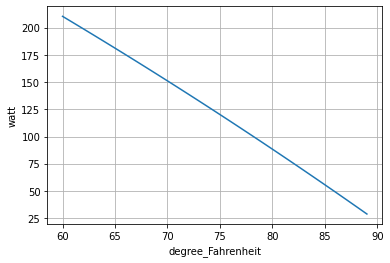

In [5]:
#Make a graph of the Power output and the temperature
plt.plot(tenv, power)
plt.grid()
#If we want a precise answer to the question, we can interpolate our data to where the power=100:



### Q3 Wet bulb temperature
The equation for the wet-bulb temperature is rather complex. But we can find it using a psychometric chart, like the one from here: https://extension.psu.edu/psychrometric-chart-use. 
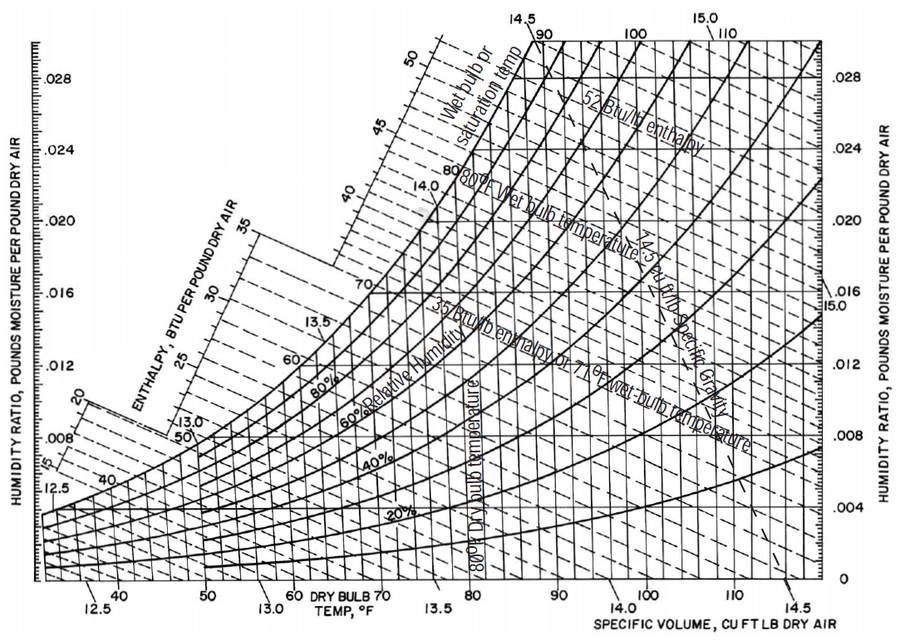

Start on the x-axis with the absolute temperature, and move up until you hit the solid curved line that represents the Relative Humidity. From there, follow the dashed lines to the left for the wet-bulb temperature, or go directly to the left for the dewpoint temperature.



### Q3.1 According to the chart, what are the Wet bulb temperature and Dew point temperature for a temperature of 80F and 70% Relative Humidity?

In [ ]:
T  = * units('degF') #FILL OUT THE NUMBERS
RH =  * units('%')
pressure = 1000 * units('mbar')
Td = calc.dewpoint_from_relative_humidity(T, RH).to(units('degF'))
Tw = calc.wet_bulb_temperature(pressure, T, Td)
print(Tw, Td)


72.28828344526623 degree_Fahrenheit 69.34743938352403 degree_Fahrenheit


What happens to the wet bulb temperature with low (20%) RH?

In [ ]:
T  =  * units('degF')#FILL OUT THE NUMBERS
RH =  * units('%')
pressure = 1000 * units('mbar')
Td = calc.dewpoint_from_relative_humidity(T, RH).to(units('degF'))
Tw = calc.wet_bulb_temperature(pressure, T, Td)
print(Tw, Td)


59.520366224428564 degree_Fahrenheit 45.82039606946953 degree_Fahrenheit


One issue with the chart is that it is only valid at sea level pressure, 1000 mbar. We just saw that the wet bulb temperature changes with pressure.

Suppose you're in Cleveland on a hot summer day (T=90F, RH=30%), just coming out of the pool. What is the wet bulb temperature? Will it feel warm or cold?

In [ ]:
T  =  * units('degF')#FILL OUT THE NUMBERS
RH = * units('%')
pressure = 1000 * units('mbar')
Td = calc.dewpoint_from_relative_humidity(T, RH).to(units('degF'))
Tw = calc.wet_bulb_temperature(pressure, T, Td)
print(Tw)

66.54973210693954 degree_Fahrenheit


Look up the pressure in Denver. With the same temperature and humidity there, will it feel cold or warm?

In [ ]:
T  =  * units('degF')#FILL OUT THE NUMBERS
RH = * units('%')
pressure = 1000 * units('mbar')
Td = calc.dewpoint_from_relative_humidity(T, RH).to(units('degF'))
Tw = calc.wet_bulb_temperature(pressure, T, Td)
print(Tw)

57.734051813192494 degree_Fahrenheit


## Q4 The 1995 Chicago Heat Wave vs the 2021 Pacific North West Heatwave
During the https://en.wikipedia.org/wiki/1995_Chicago_heat_wave, the temperature reached 104F, with a dew point of 90F. The 2021 PNW heat wave was a lot warmer, but also a lot drier. In this exercise, you will use observed data from both heat waves to compare the wet bulb temperature.

In [ ]:
#Load the PNW data, and calculate the wet bulb temperature
fname = 'PNW.nc'

data = xr.open_dataset(fname, engine='netcdf4').metpy.quantify()
time_max = data.t2m.argmax(...)['time'] #Find the time of the maximum temperature

data['tw'] = data.t2m.copy(deep=True)
data['tw'].attrs['long_name'] = '2 metre wet bulb temperature'
for t in [time_max]:
    for i in range(np.shape(data.t2m)[1]):
        for j in range(np.shape(data.t2m)[2]):
            if (~np.isnan(data.t2m[t,i,j])):
                data['tw'][t,i,j] = mpcalc.wet_bulb_temperature(data.sp[t,i,j], data.t2m[t,i,j], data.d2m[t,i,j])
data['RH'] = mpcalc.relative_humidity_from_dewpoint(data.t2m, data.d2m)
data['RH'].attrs['long_name'] = 'Relative Humidity'

np.max(data['tw'][time_max,:,:]).metpy.convert_units('degF')

In [ ]:
#Generate graphs for the wet bulb temperature and relative humidity
plot_map(data, var='t2m',time=time_max,units='degF')
plot_map(data, var='tw',time=time_max,units='degF')
plot_map(data, var='RH',time=time_max)


#QUESTIONS: What do you observe for the location and value of the peak in wetbulb temperature, in comparison with the dry bulb temperature? Why is that?

In [ ]:
#Load the Chicago data, and calculate the wet bulb temperature

QUESTION: How does the maximum wet bulb temperature during the Chicago Heatwave compare with the PNW heatwave? Also compare with recommended safety values for the wet bulb temperature.

According to Berkeley Earth (http://berkeleyearth.lbl.gov/locations/42.59N-87.27W) the temperature in Chicago has risen about 0.4C degree since. Making the reasonable assumption that Relative Humidity will stay constant, what would have been $T_w$ now, and in a climate that is 1.5C warmer than today? Comment on the answers. 

In [ ]:
#Current Climate
T  =  * units('degF') +  * units('delta_degC') #Careful here: We're adding temperatures, so we need to use the delta unit
RH =  * units('%')
pressure = 1000 * units('mbar')
# Td = 90 * units('degF')
Td = mpcalc.dewpoint_from_relative_humidity(T, RH)
Tw = mpcalc.wet_bulb_temperature(pressure, T, Td)
print(Tw)

#Future Climate
T  =  * units('degF') + * units('delta_degC') + * units('delta_degC') 
RH = * units('%')
pressure = 1000 * units('mbar')
# Td = 90 * units('degF')
Td = mpcalc.dewpoint_from_relative_humidity(T, RH)
Tw = mpcalc.wet_bulb_temperature(pressure, T, Td)
print(Tw)

93.15980293195068 degree_Fahrenheit
95.57335366889718 degree_Fahrenheit
